<a href="https://www.kaggle.com/code/seuwenfei/kpmg-virtual-internship-task-2?scriptVersionId=112926141" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Introduction**

For context, Sprocket Central Pty Ltd is a long-standing KPMG client whom specialises in high-quality bikes and accessible cycling accessories to riders. The marketing team is looking to boost business by analyzing the existing customer dataset to determine customer trends and behaviour.

After analyzing the existing 3 datasets (**customer demographic**, **customer address** and **transactions**), The **new customer list** is used to recommend which of these new customers should be targeted to bring the most value to the organization.

In [1]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kpmg-virtual-internship-dataset/KPMG_VI_New_raw_data_update_final.xlsx
/kaggle/input/australian-postcodes/australian_postcodes.csv


In [2]:
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import math

filepath = '/kaggle/input/kpmg-virtual-internship-dataset/KPMG_VI_New_raw_data_update_final.xlsx'
print(pd.ExcelFile(filepath).sheet_names)

['Title Sheet', 'Transactions', 'NewCustomerList', 'CustomerDemographic', 'CustomerAddress']


# **Data Preprocessing: CustomerDemographic**

In [3]:
demo_df = pd.read_excel(filepath, sheet_name='CustomerDemographic')

# Obtain the shape of Customer Demographic DataFrame
print(demo_df.shape)

# Obtain the information about Customer Demographic
demo_df.info()

(4000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  d

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


In [4]:
# Check number of missing values
print('Number of missing values:')
demo_df.isnull().sum()

Number of missing values:


customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
default                                302
owns_car                                 0
tenure                                  87
dtype: int64

In [5]:
# Check duplications
print('Duplicated rows:')
demo_df[demo_df.duplicated()]

Duplicated rows:


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure


In [6]:
# Check the entries for each column
for col in demo_df.columns: 
    print('{} : {}'.format(col, demo_df[col].unique()))

customer_id : [   1    2    3 ... 3998 3999 4000]
first_name : ['Laraine' 'Eli' 'Arlin' ... 'Stephie' 'Rusty' 'Sarene']
last_name : ['Medendorp' 'Bockman' 'Dearle' ... 'Halgarth' 'Woolley' 'Oldland']
gender : ['F' 'Male' 'Female' 'U' 'Femal' 'M']
past_3_years_bike_related_purchases : [93 81 61 33 56 35  6 31 97 49 99 58 38 85 91 57 79 76 72 74 43 55 12 37
  5 62 18  3 17 44 59 40 46 64 24 63 98 51 68 22  2 48 87 26 60 47 73 21
 67 16 78 30 94 28 20 11  1 75 41 69 19 80 83 25 54  4 23 65 88 10 77  9
 82 27 53 32 34 71 36 90 95  8 39  7 42 13 45 50 14 89 84 96 70 66  0 15
 86 92 29 52]
DOB : ['1953-10-12T00:00:00.000000000' '1980-12-16T00:00:00.000000000'
 '1954-01-20T00:00:00.000000000' ... '1975-12-12T00:00:00.000000000'
 '2001-07-13T00:00:00.000000000' '1991-11-05T00:00:00.000000000']
job_title : ['Executive Secretary' 'Administrative Officer' 'Recruiting Manager' nan
 'Senior Editor' 'Media Manager I' 'Business Systems Development Analyst'
 'Senior Quality Engineer' 'Nuclear Power En

In [7]:
# Remove deceased customers
demo_df = demo_df[demo_df['deceased_indicator'] == 'N']

# Drop columns
demo_df.drop(['first_name', 'last_name', 'default', 'job_title', 'deceased_indicator'], axis=1, inplace=True)

# Drop empty row 
demo_df.dropna(axis=0, inplace=True)

# Correct the value of same attribute
demo_df['gender'].replace({'M' : 'Male'}, inplace=True)
demo_df['gender'].replace({'F' : 'Female'}, inplace=True)
demo_df['gender'].replace({'Femal' : 'Female'}, inplace=True)


# Create age column
demo_df['DOB'] = pd.to_datetime(demo_df['DOB'])
demo_df['age'] = (dt.datetime.now() - demo_df['DOB']) / np.timedelta64(1, 'Y')

# Check the age range (oldest and youngest customers)
print(demo_df['age'].min(), demo_df['age'].max())

20.735983839457468 178.95689186631634


In [8]:
# Since a 178-year-old consumer is rare
# Remove customers who are older than 100
demo_df = demo_df[demo_df['age'] <= 100]

In [9]:
# Create age group column
ag = pd.Series(['20-34','35-49', '50-64', '65-79', '80-94'], dtype='category')
demo_df['age_group'] = ag

demo_df.loc[demo_df['age']<=34, 'age_group'] = ag[0]
demo_df.loc[(demo_df['age']>34) & (demo_df['age']<=49), 'age_group'] = ag[1]
demo_df.loc[(demo_df['age']>49) & (demo_df['age']<=64), 'age_group'] = ag[2]
demo_df.loc[(demo_df['age']>64) & (demo_df['age']<=79), 'age_group'] = ag[3]
demo_df.loc[demo_df['age']>79, 'age_group'] = ag[4]

print(demo_df.info())
demo_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3254 entries, 0 to 3998
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3254 non-null   int64         
 1   gender                               3254 non-null   object        
 2   past_3_years_bike_related_purchases  3254 non-null   int64         
 3   DOB                                  3254 non-null   datetime64[ns]
 4   job_industry_category                3254 non-null   object        
 5   wealth_segment                       3254 non-null   object        
 6   owns_car                             3254 non-null   object        
 7   tenure                               3254 non-null   float64       
 8   age                                  3254 non-null   float64       
 9   age_group                            3254 non-null   category      
dtypes: category(

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_group
0,1,Female,93,1953-10-12,Health,Mass Customer,Yes,11.0,69.147656,65-79
1,2,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,41.968453,35-49
2,3,Male,61,1954-01-20,Property,Mass Customer,Yes,15.0,68.873865,65-79
3,4,Male,33,1961-10-03,IT,Mass Customer,No,7.0,61.172132,50-64
5,6,Male,35,1966-09-16,Retail,High Net Worth,Yes,13.0,56.219259,50-64


# **Data Preprocessing: CustomerAddress**

In [10]:
adr_df = pd.read_excel(filepath, sheet_name='CustomerAddress')

# Obtain the shape of Customer Address DataFrame
print(adr_df.shape)

# Obtain the information about Customer Address
adr_df.info()

(3999, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [11]:
# Check duplications
print('Duplicated rows:')
adr_df[adr_df.duplicated()]

Duplicated rows:


,customer_id,address,postcode,state,country,property_valuation


In [12]:
# Check the entries for each column
for col in adr_df.columns:
    print('{} : {}'.format(col, adr_df[col].unique()))

customer_id : [   1    2    4 ... 4001 4002 4003]
address : ['060 Morning Avenue' '6 Meadow Vale Court' '0 Holy Cross Court' ...
 '87 Crescent Oaks Alley' '8194 Lien Street' '320 Acker Drive']
postcode : [2016 2153 4211 2448 3216 2210 2650 2023 3044 4557 3799 2760 2428 3331
 3058 2135 2233 2444 4413 4740 3218 4868 4116 2519 2756 2170 4005 4127
 2535 4726 4805 2212 2207 3350 3931 4018 4670 2480 3212 2322 3198 2047
 4503 2145 4350 2142 2029 2127 4280 2166 2046 2026 2765 2749 2745 3752
 2217 2230 3046 3183 2070 2213 4208 2774 4133 4213 4170 2073 3561 2330
 3977 2204 2086 2226 2075 2038 2069 2100 3133 3070 2777 2125 2766 2209
 2160 2065 2150 2168 4171 2155 2517 2096 2750 2093 3204 4300 3844 4226
 3192 2485 2097 4817 2516 3074 4508 4405 2452 2205 4132 4744 2158 3201
 4178 2112 2033 4401 3186 4017 2315 2285 2219 4509 2759 2747 2227 2025
 3191 3025 2263 2154 2119 3016 4113 2032 4352 3020 2116 3057 2099 3749
 2148 3145 2021 2333 2783 2280 4120 3638 2074 2880 2430 4560 2088 2220
 3031 2250 2261

In [13]:
# Correct the value of same attribute
adr_df['state'].replace({'New South Wales' : 'NSW'}, inplace=True)
adr_df['state'].replace({'Victoria':'VIC' }, inplace=True)
adr_df['state'].replace({'Queensland':'QLD'}, inplace=True)

In [14]:
# Load Australia postcode csv file 
AU = pd.read_csv('/kaggle/input/australian-postcodes/australian_postcodes.csv').loc[:, ['postcode','state','lat','long']]

AU.drop_duplicates(subset='postcode', inplace=True, keep='first')
AU.head()

,postcode,state,lat,long
0,200,ACT,-35.277700,149.119000
2,800,NT,-12.458684,130.836680
4,801,NT,-12.458684,130.836680
5,804,NT,-12.428017,130.873315
6,810,NT,-12.381806,130.866242


In [15]:
# Get latitude and longitude by merging two dataframes
adr_df = pd.merge(adr_df, AU, on=['postcode', 'state'], how='inner')

adr_df.head()

,customer_id,address,postcode,state,country,property_valuation,lat,long
0,1,060 Morning Avenue,2016,NSW,Australia,10,-33.894912,151.206211
1,1059,1149 Riverside Parkway,2016,NSW,Australia,11,-33.894912,151.206211
2,2172,698 Lunder Point,2016,NSW,Australia,10,-33.894912,151.206211
3,2380,4 Judy Park,2016,NSW,Australia,10,-33.894912,151.206211
4,2768,9 Cascade Junction,2016,NSW,Australia,12,-33.894912,151.206211


In [16]:
# Company: Sprocket Central Pty Ltd 
# Postcode: 3183  
# State: Victoria
# Latitude: -37.869072  &  Longitude: 144.99902

# Define a function to calculate the distance between two coordinates
# Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/
def distance(lat, long):
    radlat1 = math.pi * lat/180
    radlat2 = math.pi * -37.869072/180
    theta = long -144.99902
    radtheta = math.pi * theta/180
    dist = math.sin(radlat1) * math.sin(radlat2) + math.cos(radlat1) * math.cos(radlat2) * math.cos(radtheta);
    dist = math.acos(dist)
    dist = dist * 3956  # Distance in Mile
    return dist

# Create distance column
adr_df['distance'] = adr_df.apply(lambda x: distance(x['lat'], x['long']), axis=1)
adr_df.head()

,customer_id,address,postcode,state,country,property_valuation,lat,long,distance
0,1,060 Morning Avenue,2016,NSW,Australia,10,-33.894912,151.206211,442.3881
1,1059,1149 Riverside Parkway,2016,NSW,Australia,11,-33.894912,151.206211,442.3881
2,2172,698 Lunder Point,2016,NSW,Australia,10,-33.894912,151.206211,442.3881
3,2380,4 Judy Park,2016,NSW,Australia,10,-33.894912,151.206211,442.3881
4,2768,9 Cascade Junction,2016,NSW,Australia,12,-33.894912,151.206211,442.3881


In [17]:
# Check the distance range(shortest and longest distance)
print(round(adr_df['distance'].min(),3), round(adr_df['distance'].max(),3))

0.0 1494.127


In [18]:
# Create distance group column
range = pd.Series(['0-299', '300-599', '600-899', '900-1199', '1200-1499'])
adr_df['dist_range'] = range

adr_df.loc[adr_df['distance']<300, 'dist_range'] = range[0]
adr_df.loc[(adr_df['distance']>=300) & (adr_df['distance']<600), 'dist_range'] = range[1]
adr_df.loc[(adr_df['distance']>=600) & (adr_df['distance']<900), 'dist_range'] = range[2]
adr_df.loc[(adr_df['distance']>=900) & (adr_df['distance']<1200), 'dist_range'] = range[3]
adr_df.loc[adr_df['distance']>=1200, 'dist_range'] = range[4]

print(adr_df.info())
adr_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3994 entries, 0 to 3993
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         3994 non-null   int64  
 1   address             3994 non-null   object 
 2   postcode            3994 non-null   int64  
 3   state               3994 non-null   object 
 4   country             3994 non-null   object 
 5   property_valuation  3994 non-null   int64  
 6   lat                 3994 non-null   float64
 7   long                3994 non-null   float64
 8   distance            3994 non-null   float64
 9   dist_range          3994 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 343.2+ KB
None


,customer_id,address,postcode,state,country,property_valuation,lat,long,distance,dist_range
0,1,060 Morning Avenue,2016,NSW,Australia,10,-33.894912,151.206211,442.3881,300-599
1,1059,1149 Riverside Parkway,2016,NSW,Australia,11,-33.894912,151.206211,442.3881,300-599
2,2172,698 Lunder Point,2016,NSW,Australia,10,-33.894912,151.206211,442.3881,300-599
3,2380,4 Judy Park,2016,NSW,Australia,10,-33.894912,151.206211,442.3881,300-599
4,2768,9 Cascade Junction,2016,NSW,Australia,12,-33.894912,151.206211,442.3881,300-599


# **Data Preprocessing: Transactions**

In [19]:
txn_df = pd.read_excel(filepath, sheet_name='Transactions')

# Obtain the shape of Transactions DataFrame
print(txn_df.shape)

# Obtain the information about Transaction
txn_df.info()

(20000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_d

In [20]:
# Check number of missing values
print('Number of missing values:')
txn_df.isnull().sum()

Number of missing values:


transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [21]:
# Check duplications
print('Duplicated rows:')
txn_df[txn_df.duplicated()]

Duplicated rows:


,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date


In [22]:
# Check the entries for each column
for col in txn_df:
    print('{} : {}'.format(col, txn_df[col].unique()))

transaction_id : [   94  3765  5157 ...  8708 16701 17469]
product_id : [ 86  38  47  72   2  25  23  31  32   9  11   1  85  26  33  94  55  77
  82  90   5  95  62  34  84  39  96  13   0  54  12  22  15   3  76   4
  89  45  59  36  69   6  21  44  53  28  10  30  91  66  17  49  92  56
  68  67  41  81  99  78  70  87  97  40  16   7  48  37  20  65 100  64
  19  98  52  18  80  57  79  63  46  74  43   8  83  60  27  14  35  73
  93  50  29  75  71  24  58  51  61  88  42]
customer_id : [   1    2    3 ... 3499 3500 5034]
transaction_date : ['2017-12-23T00:00:00.000000000' '2017-04-06T00:00:00.000000000'
 '2017-05-11T00:00:00.000000000' '2017-01-05T00:00:00.000000000'
 '2017-02-21T00:00:00.000000000' '2017-05-19T00:00:00.000000000'
 '2017-03-27T00:00:00.000000000' '2017-12-14T00:00:00.000000000'
 '2017-06-04T00:00:00.000000000' '2017-12-09T00:00:00.000000000'
 '2017-03-29T00:00:00.000000000' '2017-05-04T00:00:00.000000000'
 '2017-06-11T00:00:00.000000000' '2017-08-24T00:00:00.0000

In [23]:
# Correct the data type for product_first_sold_date
txn_df['product_first_sold_date'] = pd.to_datetime(txn_df['product_first_sold_date'])

# Drop empty row 
txn_df.dropna(axis=0, inplace=True)

# Select only Approved order status
txn_df = txn_df.query("order_status == ['Approved']")

# Create profit column 
txn_df['profit'] = txn_df['list_price']-txn_df['standard_cost']

# Create recency column
txn_df['recency'] = (txn_df['transaction_date'].max()-txn_df['transaction_date'])/np.timedelta64(1,'D')

print(txn_df.info())
txn_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19273 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           19273 non-null  int64         
 1   product_id               19273 non-null  int64         
 2   customer_id              19273 non-null  int64         
 3   transaction_date         19273 non-null  datetime64[ns]
 4   online_order             19273 non-null  float64       
 5   order_status             19273 non-null  object        
 6   brand                    19273 non-null  object        
 7   product_line             19273 non-null  object        
 8   product_class            19273 non-null  object        
 9   product_size             19273 non-null  object        
 10  list_price               19273 non-null  float64       
 11  standard_cost            19273 non-null  float64       
 12  product_first_sold_date  19273 n

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,profit,recency
0,94,86,1,2017-12-23,0.0,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,1970-01-01 00:00:00.000038482,110.56,7.0
1,3765,38,1,2017-04-06,1.0,Approved,Solex,Standard,medium,medium,1577.53,826.51,1970-01-01 00:00:00.000039526,751.02,268.0
2,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,1970-01-01 00:00:00.000037823,189.28,233.0
3,9785,72,1,2017-01-05,0.0,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,1970-01-01 00:00:00.000037873,90.10,359.0
4,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,1970-01-01 00:00:00.000038573,17.87,312.0


In [24]:
# Create RFM score dataframe from Transactions dataframe
rfm_df = txn_df.groupby('customer_id').aggregate({'recency':'min', 'customer_id':'count', 'profit':'sum'})
rfm_df.rename(columns={'customer_id':'frequency'}, inplace=True)

rfm_df.head()

,recency,frequency,profit
customer_id,,,
1,7.0,11,3018.09
2,128.0,3,2226.26
3,102.0,7,3290.21
4,195.0,2,220.57
5,16.0,6,2394.94


In [25]:
# Create R, F and M score columns
# A scale of 1 - 4 was used
# 4 for quartiles [0, 0.25, 0.50, 0.75, 1]
rfm_df['r'] = pd.qcut(rfm_df['recency'], q=4, labels=[4, 3, 2, 1])  
rfm_df['f'] = pd.qcut(rfm_df['frequency'], q=4, labels=[1, 2, 3, 4])
rfm_df['m'] = pd.qcut(rfm_df['profit'], q=4, labels=[1, 2, 3, 4])

rfm_df.head()

,recency,frequency,profit,r,f,m
customer_id,,,,,,
1,7.0,11,3018.09,4,4,3
2,128.0,3,2226.26,1,1,2
3,102.0,7,3290.21,1,3,3
4,195.0,2,220.57,1,1,1
5,16.0,6,2394.94,4,3,2


In [26]:
# Create weighted RFM Score column
rfm_df['rfm_score'] = 100*rfm_df['r'].astype(int) + 10*rfm_df['f'].astype(int) + rfm_df['m'].astype(int)

# Create customer profile column
# Customer profile rankings start at Bronze, Silver, Gold and Platinum
rfm_df['customer_profile'] = pd.qcut(rfm_df['rfm_score'], q=4, labels=['Bronze', 'Silver', 'Gold', 'Platinum'])

print(rfm_df.info())
rfm_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3490 entries, 1 to 5034
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recency           3490 non-null   float64 
 1   frequency         3490 non-null   int64   
 2   profit            3490 non-null   float64 
 3   r                 3490 non-null   category
 4   f                 3490 non-null   category
 5   m                 3490 non-null   category
 6   rfm_score         3490 non-null   int64   
 7   customer_profile  3490 non-null   category
dtypes: category(4), float64(2), int64(2)
memory usage: 150.8 KB
None


,recency,frequency,profit,r,f,m,rfm_score,customer_profile
customer_id,,,,,,,,
1,7.0,11,3018.09,4,4,3,443,Platinum
2,128.0,3,2226.26,1,1,2,112,Bronze
3,102.0,7,3290.21,1,3,3,133,Bronze
4,195.0,2,220.57,1,1,1,111,Bronze
5,16.0,6,2394.94,4,3,2,432,Platinum


### **Create DataFrame for Data Insight Analysis**

In [27]:
# Join Customer Demographic, Customer Address and RFM score dataframes on customer id
dataset = rfm_df.merge(adr_df.merge(demo_df, how='inner', on='customer_id'), how='inner', on='customer_id')

print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2842 entries, 0 to 2841
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          2842 non-null   int64         
 1   recency                              2842 non-null   float64       
 2   frequency                            2842 non-null   int64         
 3   profit                               2842 non-null   float64       
 4   r                                    2842 non-null   category      
 5   f                                    2842 non-null   category      
 6   m                                    2842 non-null   category      
 7   rfm_score                            2842 non-null   int64         
 8   customer_profile                     2842 non-null   category      
 9   address                              2842 non-null   object        
 10  postcode    

,customer_id,recency,frequency,profit,r,f,m,rfm_score,customer_profile,address,...,dist_range,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_group
0,1,7.0,11,3018.09,4,4,3,443,Platinum,060 Morning Avenue,...,300-599,Female,93,1953-10-12,Health,Mass Customer,Yes,11.0,69.147656,65-79
1,2,128.0,3,2226.26,1,1,2,112,Bronze,6 Meadow Vale Court,...,300-599,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,41.968453,35-49
2,4,195.0,2,220.57,1,1,1,111,Bronze,0 Holy Cross Court,...,600-899,Male,33,1961-10-03,IT,Mass Customer,No,7.0,61.172132,50-64
3,6,64.0,5,3946.55,2,2,3,223,Silver,9 Oakridge Court,...,0-299,Male,35,1966-09-16,Retail,High Net Worth,Yes,13.0,56.219259,50-64
4,7,253.0,3,220.11,1,1,1,111,Bronze,4 Delaware Trail,...,300-599,Female,6,1976-02-23,Financial Services,Affluent Customer,Yes,11.0,46.781693,35-49


In [28]:
# Save as csv file
dataset.to_csv('dataset.csv', index=False)

# **Data Preprocessing: NewCustomerList**

In [29]:
newlist = pd.read_excel(filepath, sheet_name='NewCustomerList')

# Obtain the shape of New Customer List DataFrame
print(newlist.shape)

# Obtain the information about New Customer List
newlist.info()

(1000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  te

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


In [30]:
# Drop columns
newlist.drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 
              'Unnamed: 20'], axis=1, inplace=True)

# Check duplications
print('Duplicated rows:')
adr_df[adr_df.duplicated()]

Duplicated rows:


,customer_id,address,postcode,state,country,property_valuation,lat,long,distance,dist_range


In [31]:
# Check the entries for gender, DOB, job_industry_category, wealth_segment, deceased_indicator, 
# owns_car, state columns
listcol = ['gender', 'DOB', 'job_industry_category', 'wealth_segment', 'deceased_indicator', 
           'owns_car', 'state']

for col in listcol:
    print('{} : {}'.format(col, newlist[col].unique()))

gender : ['Male' 'Female' 'U']
DOB : ['1957-07-12T00:00:00.000000000' '1970-03-22T00:00:00.000000000'
 '1974-08-28T00:00:00.000000000' '1979-01-28T00:00:00.000000000'
 '1965-09-21T00:00:00.000000000' '1951-04-29T00:00:00.000000000'
 '1976-10-06T00:00:00.000000000' '1972-12-27T00:00:00.000000000'
 '1972-04-28T00:00:00.000000000' '1985-08-02T00:00:00.000000000'
 '1995-01-01T00:00:00.000000000' '1999-08-30T00:00:00.000000000'
 '1990-05-13T00:00:00.000000000' '1976-12-09T00:00:00.000000000'
 '1964-04-19T00:00:00.000000000' '1954-03-31T00:00:00.000000000'
 '1993-08-22T00:00:00.000000000' '1976-06-08T00:00:00.000000000'
 '1938-11-09T00:00:00.000000000' '1954-08-12T00:00:00.000000000'
 '1968-12-21T00:00:00.000000000' '1993-09-29T00:00:00.000000000'
 '1998-02-05T00:00:00.000000000' '1977-12-17T00:00:00.000000000'
 '1982-10-11T00:00:00.000000000' '1945-08-03T00:00:00.000000000'
 '1952-06-27T00:00:00.000000000' '1966-07-20T00:00:00.000000000'
 '1960-12-10T00:00:00.000000000' '1960-11-22T00:00:00

In [32]:
# Drop empty rows in DOB & job industry category
newlist.dropna(subset=['DOB', 'job_industry_category'], axis=0, inplace=True)

# Create age column
newlist['DOB'] = pd.to_datetime(newlist['DOB'])
newlist['age'] = (dt.datetime.now() - newlist['DOB']) / np.timedelta64(1, 'Y')

# Create age group column
ag = pd.Series(['20-34','35-49', '50-64', '65-79', '80-94'], dtype='category')
newlist['age_group'] = ag

newlist.loc[newlist['age']<=34, 'age_group'] = ag[0]
newlist.loc[(newlist['age']>34) & (newlist['age']<=49), 'age_group'] = ag[1]
newlist.loc[(newlist['age']>49) & (newlist['age']<=64), 'age_group'] = ag[2]
newlist.loc[(newlist['age']>64) & (newlist['age']<=79), 'age_group'] = ag[3]
newlist.loc[newlist['age']>79, 'age_group'] = ag[4]



# Create distance column
# Get latitude and longitude by merging two dataframes
newlist = pd.merge(newlist, AU, on=['postcode', 'state'], how='inner')
newlist['distance'] = newlist.apply(lambda x: distance(x['lat'], x['long']), axis=1)

# Create distance group column
range = pd.Series(['0-299', '300-599', '600-899', '900-1199', '1200-1499'])
newlist['dist_range'] = range

newlist.loc[newlist['distance']<300, 'dist_range'] = range[0]
newlist.loc[(newlist['distance']>=300) & (newlist['distance']<600), 'dist_range'] = range[1]
newlist.loc[(newlist['distance']>=600) & (newlist['distance']<900), 'dist_range'] = range[2]
newlist.loc[(newlist['distance']>=900) & (newlist['distance']<1200), 'dist_range'] = range[3]
newlist.loc[newlist['distance']>=1200, 'dist_range'] = range[4]


print(newlist.info())
newlist.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814 entries, 0 to 813
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           814 non-null    object        
 1   last_name                            791 non-null    object        
 2   gender                               814 non-null    object        
 3   past_3_years_bike_related_purchases  814 non-null    int64         
 4   DOB                                  814 non-null    datetime64[ns]
 5   job_title                            731 non-null    object        
 6   job_industry_category                814 non-null    object        
 7   wealth_segment                       814 non-null    object        
 8   deceased_indicator                   814 non-null    object        
 9   owns_car                             814 non-null    object        
 10  tenure        

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,country,property_valuation,Rank,Value,age,age_group,lat,long,distance,dist_range
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,Australia,6,1,1.71875,65.399461,65-79,-27.307845,152.939438,862.363395,600-899
1,Peria,Rantoull,Female,3,1975-03-13,Financial Analyst,Financial Services,Mass Customer,N,No,...,Australia,4,120,1.26250,47.731747,35-49,-27.307845,152.939438,862.363395,600-899
2,Madison,Lars,Male,11,1967-01-19,Health Coach III,Health,Mass Customer,N,No,...,Australia,9,620,0.75000,55.877021,50-64,-27.307845,152.939438,862.363395,600-899
3,Philbert,Bangs,Male,67,1966-03-03,Environmental Specialist,IT,Mass Customer,N,Yes,...,Australia,7,951,0.45050,56.758627,50-64,-27.307845,152.939438,862.363395,600-899
4,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,Australia,11,1,1.71875,52.706524,50-64,-33.794190,151.130233,443.606604,300-599


In [33]:
# Save as csv file 
newlist.to_csv('NewCustomerList.csv', index=False)

# **Data Insights Analysis**

## **Data Exploration**

In [34]:
df = pd.read_csv('dataset.csv')

# Set grid for all figures
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (8,6)

### **Bike related purchases in the past three years based on gender**

Text(0.5, 0, 'Gender')

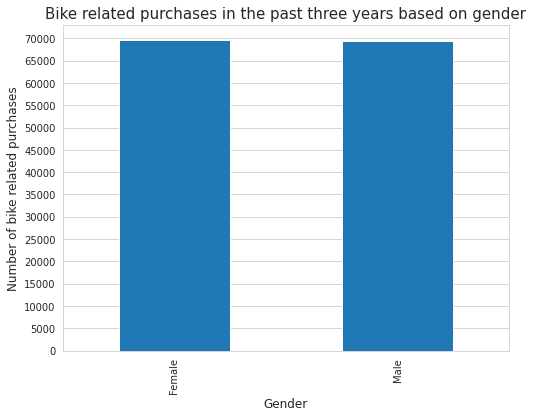

In [35]:
df1 = df.groupby('gender')['past_3_years_bike_related_purchases'].sum()
df1.plot(kind='bar')
plt.grid(axis='x')
plt.title('Bike related purchases in the past three years based on gender', fontsize=15)
plt.ylabel('Number of bike related purchases', fontsize=12)
plt.yticks(np.arange(0, 75000, 5000))
plt.xlabel('Gender', fontsize=12)

Female customers have purchased slightly more bikes than male customers over the past three years.

### **Gender ratio in customer profile**

([<matplotlib.axis.XTick at 0x7f2524e23690>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

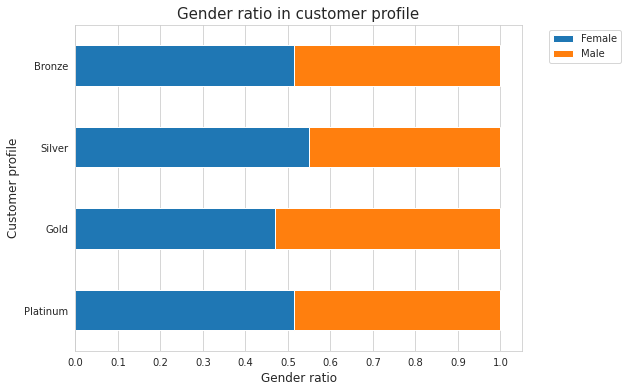

In [36]:
df2 = df.groupby(['customer_profile', 'gender']).size().unstack()
sort_cp = ['Platinum', 'Gold', 'Silver', 'Bronze']
df2 = df2.loc[sort_cp]

df2.apply(lambda x : x/x.sum(), axis=1).plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.title('Gender ratio in customer profile', fontsize=15)
plt.ylabel('Customer profile', fontsize=12)
plt.xlabel('Gender ratio', fontsize=12)
plt.xticks(np.arange(0, 1+0.1, 0.1))

Female customers have the slightly higher ratio than male customers for all other customer profiles except the Gold profile. Therefore, female could represent more potential buyers.

### **Total profit by age group and wealth segment**

Text(0.5, 0, 'Age group')

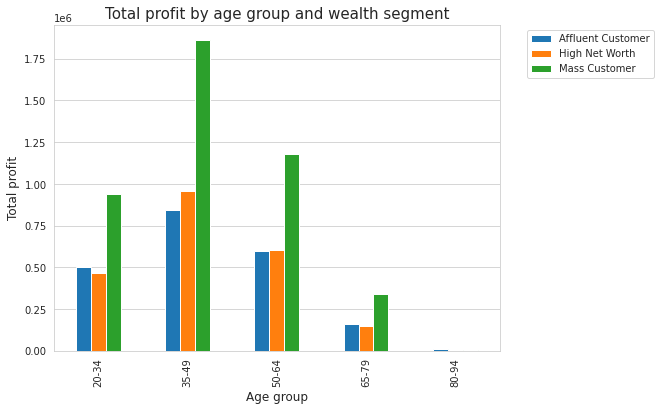

In [37]:
df3 = df.groupby(['age_group', 'wealth_segment'])['profit'].sum().unstack().fillna(0)

df3.plot(kind='bar')
plt.grid(axis = 'x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Total profit by age group and wealth segment', fontsize=15)
plt.ylabel('Total profit', fontsize=12)
plt.xlabel('Age group', fontsize=12)

* The mass customer wealth segment is the most profitable across all age groups except the 80-94 age group.

* Based on age group, mass customers between the ages of 35 and 49 has the highest profit.

* Overall, the purchasing power tends to rise until age 49; after that, it begins to decline.

* Mass customers between the ages of 35 and 49 are likely to be high potential value customers.

### **Total profit by job industry category**

Text(0.5, 0, 'Job industry category')

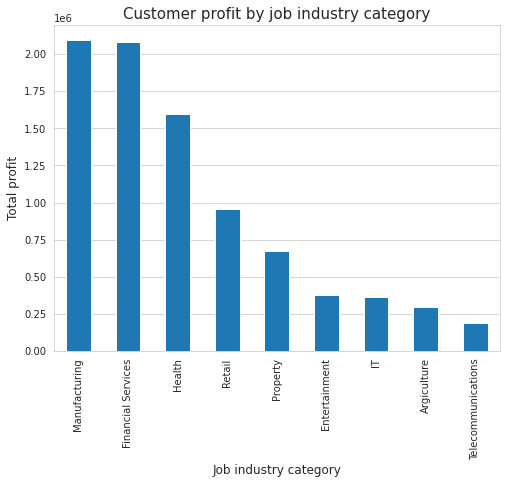

In [38]:
df4 = df.groupby('job_industry_category')['profit'].sum()
df4 = df4.sort_values(ascending=False)

df4.plot(kind='bar')
plt.grid(axis='x')
plt.title('Customer profit by job industry category', fontsize=15)
plt.ylabel('Total profit', fontsize=12)
plt.xlabel('Job industry category', fontsize=12)

The top three employment industries with high customer profit are manufacturing, financial services, and health, so these job industries may have more potential high value customers.

### **Number of customers with and without cars in each state**

Text(0.5, 0, 'State')

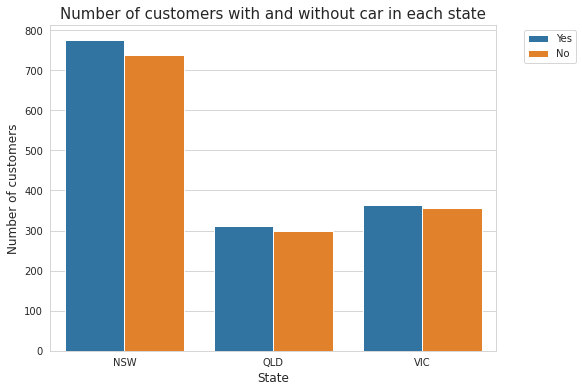

In [39]:
sns.countplot(x='state', hue='owns_car', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Number of customers with and without car in each state', fontsize=15)
plt.ylabel('Number of customers', fontsize=12)
plt.xlabel('State', fontsize=12)

* In each state, slightly more customers who own a car buy bike than those who without car.

* New South Wales (NSW), Queensland (QLD) and Victoria (VIC) could be potential market opportunities for the company.

* The state of NSW has the most potential as the number of customers who own a car is almost equal to the number of customers who don't. This demonstrates that there is an opportunity to bring in profitable customers.

### **Total profit by distance range in each state**

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 72.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 39.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


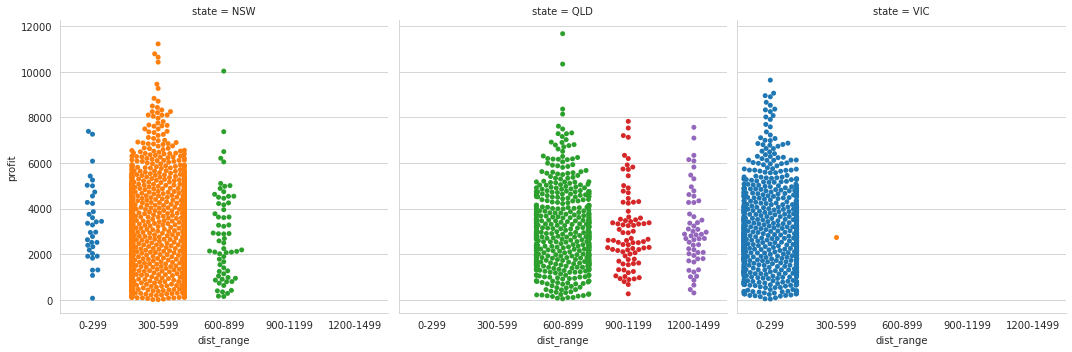

In [40]:
dist_sort = ['0-299','300-599','600-899','900-1199','1200-1499']

sns.catplot(data=df, y='profit', x='dist_range', kind='swarm', col='state', order=dist_sort)

* In New South Wales (NSW), the distance between customers and office is between 0 and 899 miles, with most customers between 300 and 599 miles. Therefore, NSW customers located 300 and 599 miles from the office may represent profitable customers.

* Customers in Queensland (QLD) are distributed across between 600 and 1499 miles from the office, with the majority being between 600 and 899 miles. Customers from QLD who live 600 and 899 miles away from the office may therefore be high-value potential.

* Customers are ranged out between 0 and 599 miles from the office in Victoria (VIC). The majority of VIC customers are between 0 and 299 miles away from the office, thus they might be high-value potential customers.

### **Number of customers with and without car in each customer profile**

Text(0.5, 0, 'Customer profile')

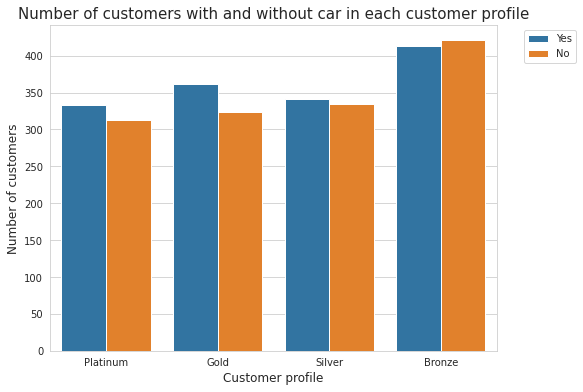

In [41]:
sns.countplot(data=df, x='customer_profile', hue='owns_car', order=['Platinum', 'Gold', 'Silver', 'Bronze'])
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.title('Number of customers with and without car in each customer profile', fontsize=15)
plt.ylabel('Number of customers', fontsize=12)
plt.xlabel('Customer profile', fontsize=12)

In the Bronze profile, there are more customers who do not own a car than those who do. However, when the customer profile level increases, there are more customers who own a car than those who do not.

## **Hypothesis Testing**


### **Customer profile and gender**

Determine if there is evidence that gender affects customer profile.

H₀: The customer profile and gender are independent.

H₁: The customer profile and gender are dependent.

In [42]:
crosstab_1 = pd.crosstab(df['customer_profile'], df['gender'], margins=True, margins_name='Total')

alpha = 0.05

chisquare_1 = 0
rows_1 = df['customer_profile'].unique()
columns_1 = df['gender'].unique()
for i in columns_1:
    for j in rows_1:
        O = crosstab_1[i][j]
        E = crosstab_1[i]['Total'] * crosstab_1['Total'][j] / crosstab_1['Total']['Total']
        chisquare_1 += (O-E)**2/E

p_value_1 = 1 - stats.chi2.cdf(chisquare_1, (len(rows_1)-1)*(len(columns_1)-1))

conclusion_1 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and gender are are independent.'
if p_value_1 <= alpha:
    conclusion_1 = 'Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and gender are dependent.'
        
print('chi-squared statistic is:', round(chisquare_1,4), ' and p value is:', round(p_value_1,4))
print(conclusion_1)

chi-squared statistic is: 8.6794  and p value is: 0.0339
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and gender are dependent.


### **Customer profile and age group**

Determine if there is evidence that age group affects customer profile.

H₀: The customer profile and age group are independent.

H₁: The customer profile and age group are dependent.

In [43]:
crosstab_2 = pd.crosstab(df['customer_profile'], df['age_group'], margins=True, margins_name='Total')

chisquare_2 = 0

rows_2 = df['customer_profile'].unique()
columns_2 = df['age_group'].unique()
for i in columns_2:
    for j in rows_2:
        O = crosstab_2[i][j]
        E = crosstab_2[i]['Total'] * crosstab_2['Total'][j] / crosstab_2['Total']['Total']
        chisquare_2 += (O+E)**2/E

p_value_2 = 1 - stats.chi2.cdf(chisquare_2, (len(rows_2)-1), (len(columns_2)-1))

conclusion_2 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and age group are independent.'
if p_value_2 <= alpha:
    conclusion_2 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and age group are dependent."

print("chi-squared statistic is:", round(chisquare_2,4), " and p value is:", round(p_value_2,4))
print(conclusion_2)

chi-squared statistic is: 11382.4988  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and age group are dependent.


### **Customer profile and wealth segment**

Determine if there is evidence that wealth segment affects customer profile.

H₀: The customer profile and wealth segment are independent.

H₁: The customer profile and wealth segment are dependent.

In [44]:
crosstab_3 = pd.crosstab(df['customer_profile'], df['wealth_segment'], margins=True, margins_name='Total')

chisquare_3 = 0

rows_3 = df['customer_profile'].unique()
columns_3 = df['wealth_segment'].unique()
for i in columns_3:
    for j in rows_3:
        O = crosstab_3[i][j]
        E = crosstab_3[i]['Total'] * crosstab_3['Total'][j] / crosstab_3['Total']['Total']
        chisquare_3 += (O+E)**2/E

p_value_3 = 1 - stats.chi2.cdf(chisquare_3, (len(rows_3)-1), (len(columns_3)-1))

conclusion_3 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and wealth segment are independent.'
if p_value_3 <= alpha:
    conclusion_3 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and wealth segment are dependent."

print("chi-squared statistic is:", round(chisquare_3,4), " and p value is:", round(p_value_3,4))
print(conclusion_3)

chi-squared statistic is: 11374.5069  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and wealth segment are dependent.


### **Customer profile and job industry category**

Determine if there is evidence that job industry category affects customer profile.

H₀: The customer profile and job industry category are independent.

H₁: The customer profile and job industry category are dependent.

In [45]:
crosstab_4 = pd.crosstab(df['customer_profile'], df['job_industry_category'], margins=True, margins_name='Total')

chisquare_4 = 0

rows_4 = df['customer_profile'].unique()
columns_4 = df['job_industry_category'].unique()
for i in columns_4:
    for j in rows_4:
        O = crosstab_4[i][j]
        E = crosstab_4[i]['Total'] * crosstab_4['Total'][j] / crosstab_4['Total']['Total']
        chisquare_4 += (O+E)**2/E

p_value_4 = 1 - stats.chi2.cdf(chisquare_4, (len(rows_4)-1), (len(columns_4)-1))

conclusion_4 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and job industry category are independent.'
if p_value_4 <= alpha:
    conclusion_4 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and job industry category are dependent."

print("chi-squared statistic is:", round(chisquare_4,4), " and p value is:", round(p_value_4,4))
print(conclusion_4)

chi-squared statistic is: 11400.6735  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and job industry category are dependent.


### **Customer profile and distance range in NSW**

Determine if there is evidence that distance from NSW customer locations to Sprocket Central Pty Ltd affects customer profile.

H₀: The customer profile and distance range in NSW are independent.

H₁: The customer profile and distance range in NSW are dependent.

In [46]:
df5 = df[['customer_profile', 'dist_range', 'state']]
df5 = df5[df5['state']=='NSW']

crosstab_5 = pd.crosstab(df5['customer_profile'], df5['dist_range'], margins=True, margins_name='Total')

chisquare_5 = 0

rows_5 = df5['customer_profile'].unique()
columns_5 = df5['dist_range'].unique()
for i in columns_5:
    for j in rows_5:
        O = crosstab_5[i][j]
        E = crosstab_5[i]['Total'] * crosstab_5['Total'][j] / crosstab_5['Total']['Total']
        chisquare_5 += (O+E)**2/E

p_value_5 = 1 - stats.chi2.cdf(chisquare_5, (len(rows_5)-1), (len(columns_5)-1))

conclusion_5 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and distance range in NSW are independent.'
if p_value_5 <= alpha:
    conclusion_5 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and distance range in NSW are dependent."

print("chi-squared statistic is:", round(chisquare_5,4), " and p value is:", round(p_value_5,4))
print(conclusion_5)

chi-squared statistic is: 6058.2323  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and distance range in NSW are dependent.


### **Customer profile and distance range in QLD**

Determine if there is evidence that distance from QLD customer locations to Sprocket Central Pty Ltd affects customer profile.

H₀: The customer profile and distance range in QLD are independent.

H₁: The customer profile and distance range in QLD are dependent.

In [47]:
df6 = df[['customer_profile', 'dist_range', 'state']]
df6 = df6[df6['state']=='VIC']

crosstab_6 = pd.crosstab(df6['customer_profile'], df6['state'], margins=True, margins_name='Total')

chisquare_6 = 0

rows_6 = df6['customer_profile'].unique()
columns_6 = df6['state'].unique()
for i in columns_6:
    for j in rows_6:
        O = crosstab_6[i][j]
        E = crosstab_6[i]['Total'] * crosstab_6['Total'][j] / crosstab_6['Total']['Total']
        chisquare_6 += (O+E)**2/E

p_value_6 = 1 - stats.chi2.cdf(chisquare_6, (len(rows_6)-1), (len(columns_6)-1))

conclusion_6 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and distance range in QLD are independent.'
if p_value_6 <= alpha:
    conclusion_6 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and distance range in QLD are dependent."

print("chi-squared statistic is:", round(chisquare_6,4), " and p value is:", round(p_value_6,4))
print(conclusion_6)

chi-squared statistic is: 2876.0  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and distance range in QLD are dependent.


### **Customer profile and distance range in VIC**

Determine if there is evidence that distance from VIC customer locations to Sprocket Central Pty Ltd affects customer profile.

H₀: The customer profile and distance range in VIC are independent.

H₁: The customer profile and distance range in VIC are dependent.

In [48]:
df7 = df[['customer_profile', 'dist_range', 'state']]
df7 = df7[df7['state']=='VIC']

crosstab_7 = pd.crosstab(df7['customer_profile'], df7['dist_range'], margins=True, margins_name='Total')

chisquare_7 = 0

rows_7 = df7['customer_profile'].unique()
columns_7 = df7['dist_range'].unique()
for i in columns_7:
    for j in rows_7:
        O = crosstab_7[i][j]
        E = crosstab_7[i]['Total'] * crosstab_7['Total'][j] / crosstab_7['Total']['Total']
        chisquare_7 += (O+E)**2/E

p_value_7 = 1 - stats.chi2.cdf(chisquare_7, (len(rows_7)-1), (len(columns_7)-1))

conclusion_7 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and distance range in VIC are independent.'
if p_value_7 <= alpha:
    conclusion_7 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and distance range in VIC are dependent."

print("chi-squared statistic is:", round(chisquare_7,4), " and p value is:", round(p_value_7,4))
print(conclusion_7)

chi-squared statistic is: 2879.5269  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and distance range in VIC are dependent.


### **Customer profile and car ownership**

Determine if there is evidence that customer ownership of a car affects the customer profile.

H₀: The customer profile and customer ownership of a car are independent.

H₁: The customer profile and customer ownership of a car are dependent.

In [49]:
crosstab_8 = pd.crosstab(df['customer_profile'], df['owns_car'], margins=True, margins_name='Total')

chisquare_8 = 0

rows_8 = df['customer_profile'].unique()
columns_8 = df['owns_car'].unique()
for i in columns_8:
    for j in rows_8:
        O = crosstab_8[i][j]
        E = crosstab_8[i]['Total'] * crosstab_7['Total'][j] / crosstab_7['Total']['Total']
        chisquare_8 += (O+E)**2/E

p_value_8 = 1 - stats.chi2.cdf(chisquare_8, (len(rows_8)-1), (len(columns_8)-1))

conclusion_8 = 'Failed to reject the null hypothesis because p-value > 0.05. Therefore, customer profile and customer ownership of a car are independent.'
if p_value_8 <= alpha:
    conclusion_8 = "Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and customer ownership of a car are dependent."

print("chi-squared statistic is:", round(chisquare_8,4), " and p value is:", round(p_value_8,4))
print(conclusion_8)

chi-squared statistic is: 11378.5045  and p value is: 0.0
Null Hypothesis is rejected because p-value <= 0.05. Therefore, customer profile and customer ownership of a car are dependent.


# **Conclusion**


## **Recommend potential high-value customers**

**Customer Classification** – **Targeting High Value Customers**
The following are the high-value customers to target from the new list :

* **Gender:** Female
* **Age group:** 35 – 49
* **Wealth segment:** Mass customer
* **Job industry categories:** Manufacturing, Financial Services, and Health
* **State & distance range:** (NSW & 300-599), (QLD & 600-899), (VIC & 0-299)
* **Car ownership:** Yes

In [50]:
reco = pd.read_csv('NewCustomerList.csv')

reco = reco[(reco['age_group']=='35-49') & (reco['wealth_segment']=='Mass Customer') & 
                  (reco['owns_car']=='Yes') & (reco['gender']=='Female') & 
                  (reco['job_industry_category'].isin(['Manufacturing','Financial Services','Health'])) &
                  ( ((reco['state']=='NSW') & (reco['dist_range']=='300-599')) | 
                  ((reco['state']=='QLD') & (reco['dist_range']=='600-899')) | 
                  ((reco['state']=='VIC') & (reco['dist_range']=='0-299')) )
                  ]

reco = reco.loc[:, ['first_name', 'last_name', 'gender', 'DOB', 'job_industry_category', 'wealth_segment', 'owns_car', 'state']]

print('It is recommended to target {} customers to bring maximum value to the organization.\n'.format(reco.shape[0]))

print('High potential value customers are as follows:')
pd.set_option('display.max_rows', None)
reco

It is recommended to target 19 customers to bring maximum value to the organization.

High potential value customers are as follows:


,first_name,last_name,gender,DOB,job_industry_category,wealth_segment,owns_car,state
84,Gale,Disbrow,Female,1977-05-14,Financial Services,Mass Customer,Yes,VIC
228,Daryl,Pauncefort,Female,1979-06-18,Financial Services,Mass Customer,Yes,NSW
289,Katleen,Arnoult,Female,1976-11-24,Manufacturing,Mass Customer,Yes,NSW
291,Jammie,Seldner,Female,1975-02-25,Health,Mass Customer,Yes,NSW
327,Amabel,NaN,Female,1981-09-14,Financial Services,Mass Customer,Yes,NSW
411,Raye,Roo,Female,1976-03-07,Financial Services,Mass Customer,Yes,VIC
427,Biddie,Gorce,Female,1988-01-30,Financial Services,Mass Customer,Yes,NSW
458,Ajay,Worham,Female,1979-09-30,Manufacturing,Mass Customer,Yes,NSW
497,Leisha,McConway,Female,1975-10-31,Financial Services,Mass Customer,Yes,VIC
526,Dodi,Kiggel,Female,1980-08-15,Financial Services,Mass Customer,Yes,NSW
